In [26]:
import pandas as pd
import numpy as np 
from rdkit import Chem 
from rdkit import DataStructs 
from rdkit.Chem import AllChem 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
from dscribe.descriptors import LMBTR
import ase, ase.io
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [27]:
warnings.filterwarnings("ignore")

# Extract the Energy data from each structure

In [28]:
data_array = []
for i in range (1, 217):
    df = pd.read_csv("/Users/schwegler2/Downloads/XANES_amorphous_data/density_1.5/density_1.5_amorphous_1/amorphous-amorphous_20.C" + str(i).zfill(3) + "-XCH.xas.5.xas", sep = '\s+', skiprows=1)
    array = df[['energy']].to_numpy()
    data_array.append(array)

In [29]:
data_array = np.array(data_array)
flattened_data_array = data_array.reshape(216, -1)
flattened_data_array = np.array(flattened_data_array)

In [30]:
data_array2 = []
full_array = []
full_array.append(flattened_data_array)

for z in range(2, 21):
    for i in range (1, 217):
        df = pd.read_csv("/Users/schwegler2/Downloads/XANES_amorphous_data/density_1.5/density_1.5_amorphous_" + str(z) + "/amorphous-amorphous.C" + str(i).zfill(3) + "-XCH.xas.5.xas", sep = '\s+', skiprows=1)
        array2 = df[['energy']].to_numpy() 
        data_array2.append(array2)
    data_array2 = np.array(data_array2)
    flattened_data_array2 = data_array2.reshape(216, -1)
    flattened_data_array2 = np.array(flattened_data_array2)
    full_array.append(flattened_data_array2)
    data_array2 = data_array2.tolist()
    data_array2 = []

In [31]:
for z in range(1, 17):
    for i in range (1, 217):
        df = pd.read_csv("/Users/schwegler2/Downloads/XANES_amorphous_data/density_2.0/amorphous_density_2.0_" + str(z) + "/amorphous-amorphous.C" + str(i).zfill(3) + "-XCH.xas.5.xas", sep = '\s+', skiprows=1)
        array2 = df[['energy']].to_numpy() 
        data_array2.append(array2)
    data_array2 = np.array(data_array2)
    flattened_data_array2 = data_array2.reshape(216, -1)
    flattened_data_array2 = np.array(flattened_data_array2)
    full_array.append(flattened_data_array2)
    data_array2 = data_array2.tolist()
    data_array2 = []

In [32]:
for i in range (1, 217):
    df = pd.read_csv("/Users/schwegler2/Downloads/XANES_amorphous_data/various_densities/amorphous_11/amorphous_11-amorphous_11.C" + str(i).zfill(3) + "-XCH.xas.5.xas", sep = '\s+', skiprows=1)
    array2 = df[['energy']].to_numpy() 
    data_array2.append(array2)
data_array2 = np.array(data_array2)
flattened_data_array2 = data_array2.reshape(216, -1)
flattened_data_array2 = np.array(flattened_data_array2)
full_array.append(flattened_data_array2)
data_array2 = data_array2.tolist()
data_array2 = []

In [33]:
for z in range(13, 21):
    for i in range (1, 217):
        df = pd.read_csv("/Users/schwegler2/Downloads/XANES_amorphous_data/various_densities/amorphous_" + str(z) + "/amorphous_" + str(z) + "-amorphous_" + str(z) + ".C" + str(i).zfill(3) + "-XCH.xas.5.xas", sep = '\s+', skiprows=1)
        array2 = df[['energy']].to_numpy() 
        data_array2.append(array2)
    data_array2 = np.array(data_array2)
    flattened_data_array2 = data_array2.reshape(216, -1)
    flattened_data_array2 = np.array(flattened_data_array2)
    full_array.append(flattened_data_array2)
    data_array2 = data_array2.tolist()
    data_array2 = []

In [34]:
full_array = np.array(full_array)
full_array.shape

(45, 216, 2000)

### Array of 45 structures each containing 216 atoms.

# Convert the .xyz data into LMBTR 

In [35]:
full_features = []
for l in range(1, 21):
    ase_crystal = ase.io.read("/Users/schwegler2/Downloads/XANES_amorphous_data/density_1.5/amorphous_density_1.5_" + str(l) + ".xyz")
    elements = [list(set(ase_crystal.get_chemical_symbols()))]
    species = list(set(sum(elements, [])))
    species.sort()
    num_species = len(species)
    
    make_feature_LMBTR_k2 = LMBTR(
        species=["C"],
        geometry={"function": "distance"},
        grid={"min": 1, "max": 5, "n": 200, 
              "sigma": 0.05},
        weighting={"function": "exp", "scale": 1, "threshold": 1e-2},
        periodic=True,normalization="none",)
    
    features_LMBTR_k2 = make_feature_LMBTR_k2.create(ase_crystal)

    make_feature_LMBTR_k3 = LMBTR(
        species=["C"],
        geometry={"function": "angle"},
        grid={"min": 1, "max": 180, "n": 200, 
              "sigma": 0.1},
        weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
        periodic=True,normalization="none",)
    
    features_LMBTR_k3 = make_feature_LMBTR_k3.create(ase_crystal)
    features_LMBTR = []
    for i in range(216):
        features_LMBTR.append(np.concatenate((features_LMBTR_k2[i],features_LMBTR_k3[i]), axis=0))
    features_LMBTR = np.array(features_LMBTR)
    full_features.append(features_LMBTR)

In [36]:
for l in range(1, 17):
    ase_crystal = ase.io.read("/Users/schwegler2/Downloads/XANES_amorphous_data/density_2.0/amorphous_density_2.0_" + str(l) + ".xyz")
    elements = [list(set(ase_crystal.get_chemical_symbols()))]
    species = list(set(sum(elements, [])))
    species.sort()
    num_species = len(species)
    
    make_feature_LMBTR_k2 = LMBTR(
        species=["C"],
        geometry={"function": "distance"},
        grid={"min": 1, "max": 5, "n": 200, 
              "sigma": 0.05},
        weighting={"function": "exp", "scale": 1, "threshold": 1e-2},
        periodic=True,normalization="none",)
    
    features_LMBTR_k2 = make_feature_LMBTR_k2.create(ase_crystal)

    make_feature_LMBTR_k3 = LMBTR(
        species=["C"],
        geometry={"function": "angle"},
        grid={"min": 1, "max": 180, "n": 200, 
              "sigma": 0.1},
        weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
        periodic=True,normalization="none",)
    
    features_LMBTR_k3 = make_feature_LMBTR_k3.create(ase_crystal)
    features_LMBTR = []
    for i in range(216):
        features_LMBTR.append(np.concatenate((features_LMBTR_k2[i],features_LMBTR_k3[i]), axis=0))
    features_LMBTR = np.array(features_LMBTR)
    full_features.append(features_LMBTR)

In [37]:
ase_crystal = ase.io.read("/Users/schwegler2/Downloads/XANES_amorphous_data/various_densities/amorphous_11.xyz")
elements = [list(set(ase_crystal.get_chemical_symbols()))]
species = list(set(sum(elements, [])))
species.sort()
num_species = len(species)
    
make_feature_LMBTR_k2 = LMBTR(
    species=["C"],
    geometry={"function": "distance"},
    grid={"min": 1, "max": 5, "n": 200, 
            "sigma": 0.05},
    weighting={"function": "exp", "scale": 1, "threshold": 1e-2},
    periodic=True,normalization="none",)
    
features_LMBTR_k2 = make_feature_LMBTR_k2.create(ase_crystal)

make_feature_LMBTR_k3 = LMBTR(
    species=["C"],
    geometry={"function": "angle"},
    grid={"min": 1, "max": 180, "n": 200, 
            "sigma": 0.1},
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
    periodic=True,normalization="none",)
    
features_LMBTR_k3 = make_feature_LMBTR_k3.create(ase_crystal)
features_LMBTR = []
for i in range(216):
    features_LMBTR.append(np.concatenate((features_LMBTR_k2[i],features_LMBTR_k3[i]), axis=0))
features_LMBTR = np.array(features_LMBTR)
full_features.append(features_LMBTR)

In [38]:
for l in range(13, 21):
    ase_crystal = ase.io.read("/Users/schwegler2/Downloads/XANES_amorphous_data/various_densities/amorphous_" + str(l)+ ".xyz")
    elements = [list(set(ase_crystal.get_chemical_symbols()))]
    species = list(set(sum(elements, [])))
    species.sort()
    num_species = len(species)
    
    make_feature_LMBTR_k2 = LMBTR(
        species=["C"],
        geometry={"function": "distance"},
        grid={"min": 1, "max": 5, "n": 200, 
              "sigma": 0.05},
        weighting={"function": "exp", "scale": 1, "threshold": 1e-2},
        periodic=True,normalization="none",)
    
    features_LMBTR_k2 = make_feature_LMBTR_k2.create(ase_crystal)

    make_feature_LMBTR_k3 = LMBTR(
        species=["C"],
        geometry={"function": "angle"},
        grid={"min": 1, "max": 180, "n": 200, 
              "sigma": 0.1},
        weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},
        periodic=True,normalization="none",)
    
    features_LMBTR_k3 = make_feature_LMBTR_k3.create(ase_crystal)
    features_LMBTR = []
    for i in range(216):
        features_LMBTR.append(np.concatenate((features_LMBTR_k2[i],features_LMBTR_k3[i]), axis=0))
    features_LMBTR = np.array(features_LMBTR)
    full_features.append(features_LMBTR)

In [39]:
full_features = np.array(full_features)
full_features.shape

(45, 216, 1400)

### Array of 45 structures with 216 atoms. 

# Create the train/test split (70 train/30 test)

In [40]:
for i in range (0, 20):
    X_train, X_test, Y_train, Y_test = train_test_split(full_features[i],
                                                    full_array[i],
                                                    train_size=.7,
                                                    random_state=25)
    
    if i == 0:
        trainY = Y_train
        trainX = X_train

        testY = Y_test
        testX = X_test

    elif i == 1:
        stacked_trainY = np.row_stack((trainY, Y_train))
        stacked_trainX = np.row_stack((trainX, X_train))

        stacked_testY = np.row_stack((testY, Y_test))
        stacked_testX = np.row_stack((testX, X_test))

    else: 
        stacked_trainY = np.row_stack((stacked_trainY, Y_train))
        stacked_trainX = np.row_stack((stacked_trainX, X_train))

        stacked_testY = np.row_stack((stacked_testY, Y_test))
        stacked_testX = np.row_stack((stacked_testX, X_test))

# Create the neural network architecture 

In [41]:
model = Sequential()

model.add(Dense(1400, input_dim=(1400), activation='softmax'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(300,activation='softmax'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(200,activation='softmax'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(2000,activation='softmax'))
model.add(BatchNormalization())
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1400)           │     1,961,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1400)           │         5,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 300)            │       420,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2000)           │       402,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,500 (10.91 MB)

 Trainable params: 2,851,700 (10.88 MB)

 Non-trainable params: 7,800 (30.47 KB)

# Fit the model with the training data 

In [42]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mae", metrics=["mae","KLDivergence"])
history = model.fit(X_train, Y_train, epochs=3500, batch_size=32)

Epoch 1/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - KLDivergence: 56.8141 - loss: 0.0047 - mae: 0.0047   
Epoch 2/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - KLDivergence: 4.2226 - loss: 0.0022 - mae: 0.0022 
Epoch 3/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - KLDivergence: 0.0923 - loss: 0.0021 - mae: 0.0021
Epoch 4/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - KLDivergence: 0.5324 - loss: 0.0020 - mae: 0.0020
Epoch 5/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - KLDivergence: 2.0392 - loss: 0.0018 - mae: 0.0018
Epoch 6/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - KLDivergence: 2.6102 - loss: 0.0018 - mae: 0.0018
Epoch 7/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - KLDivergence: 2.5828 - loss: 0.0018 - mae: 0.0018
Epoch 8/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - KLDivergence: 2.4216 - loss: 0.0017 - mae: 0.0017
Epoch 9/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - KLDivergence: 2.3377 - loss: 0.0017 - mae: 0.0017
Epoch 10/3500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - KLDivergence: 2.

# Plot the epoch - mae graph 

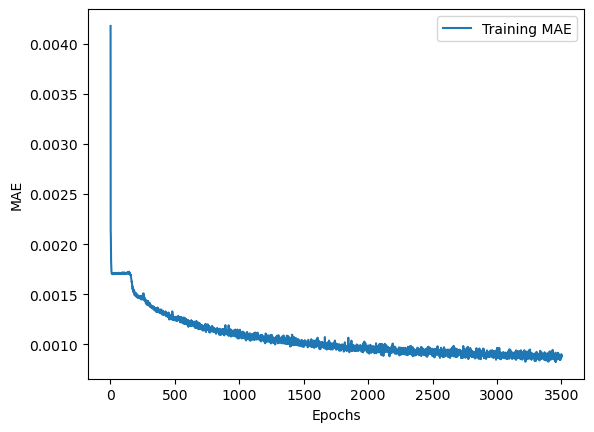

In [43]:
mae = history.history['mae'] 
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, label='Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Visualize predicted and actual specturms 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


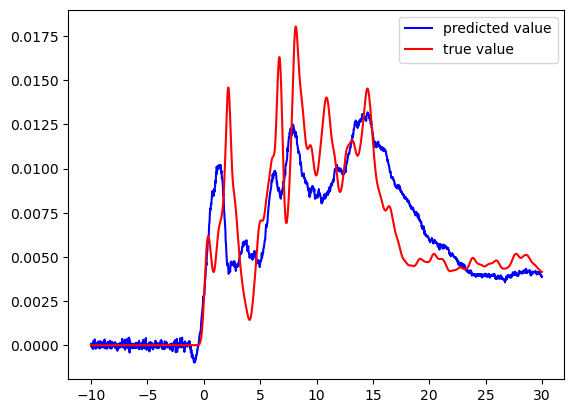

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


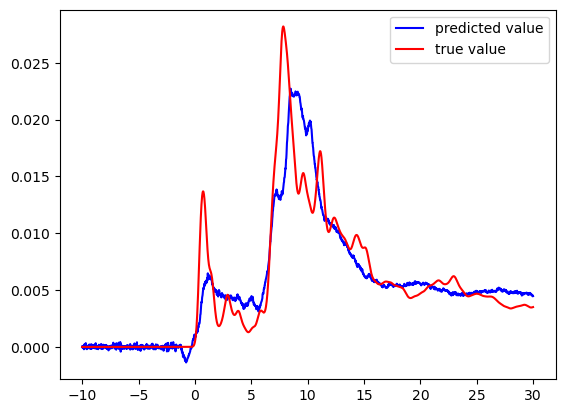

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


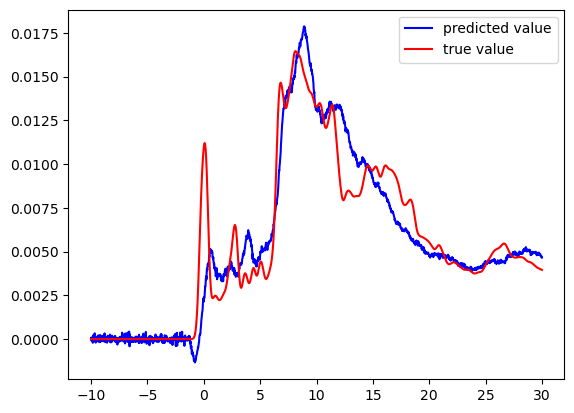

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


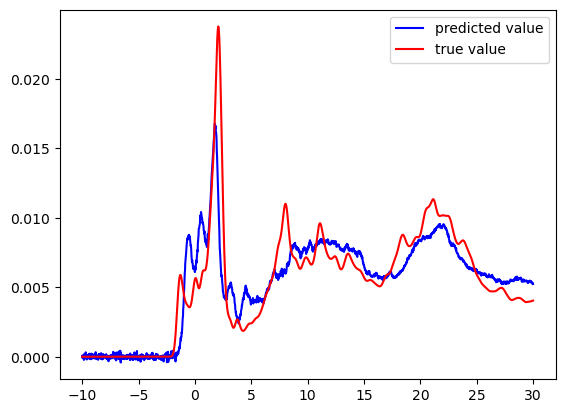

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


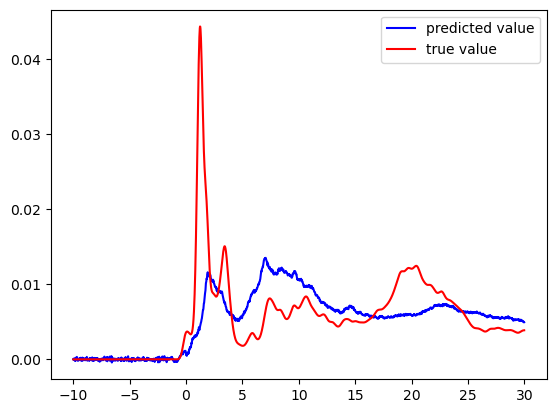

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


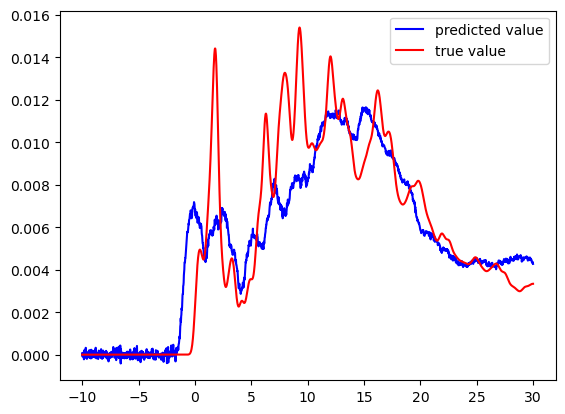

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


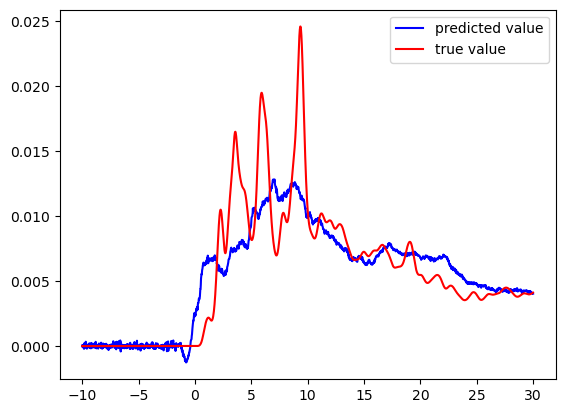

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


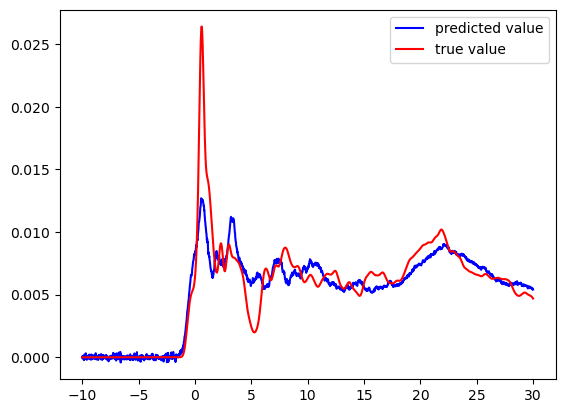

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


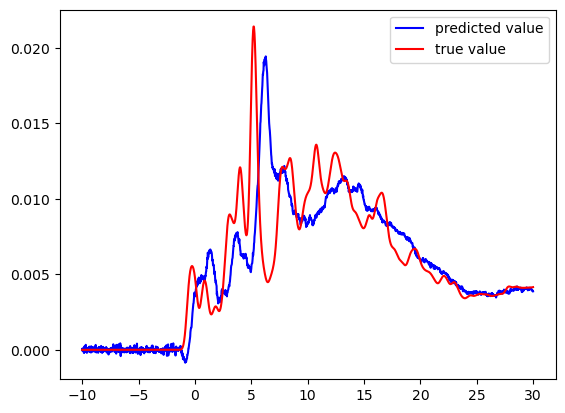

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


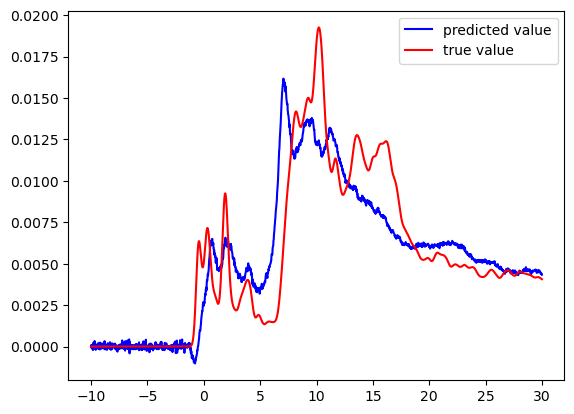

In [44]:
for i in range(0,10):
    y_predicted = model.predict(X_test[i:i+1])
    plt.plot(df['#'].to_numpy(), y_predicted.flatten(),color='blue',label = 'predicted value')
    plt.plot(df['#'].to_numpy(), np.array(Y_test[i:i+1]).flatten(),color='red', label = 'true value')
    plt.legend()
    plt.show() 